# Section 5.1: Partial sensitivity analysis of multivariate database queries

In [2]:
from deuterium import Variable, to_vec, random_symbols, get_gradients
import numpy as np
from functools import partial
from sympy import sympify
import sympy as sy
import symengine as se
from scipy.optimize import shgo

Set up a fictional database query

In [3]:
def f(x,y):
    return x**3 + 2*x*y + 1/y**2 + 5 + np.sqrt(x+np.log(y)) + np.exp(x*y) - 2*np.sqrt(np.exp(x))

Create an array of symbolic inputs

In [4]:
x = to_vec(np.array(random_symbols(2, "x")))

Evaluate the function on the symbolic inputs

In [5]:
y = f(*x)

The next cell is not required for the flow of computation, it just prints out the result as a formula

In [6]:
sympify(y.data).simplify(rational=True)

x_0**3 + 2*x_0*x_1 + sqrt(x_0 + log(x_1)) - 2*sqrt(exp(x_0)) + exp(x_0*x_1) + 5 + x_1**(-2)

The `get_gradients` function is an alternative way to `.backward()` to obtain gradients which allows to directly get a dictionary of gradients. The next cell could therefore also be obtained by calling `.backward()`.

In [7]:
grads = get_gradients(y, wrt=("x_0", "x_1"))
grads

{'x_0': 2.0*x_1 - 1.0*exp(x_0)*(exp(x_0))**(-0.5) + 1.0*exp(x_1*x_0)*x_1 + 3.0*x_0**2.0 + 0.5*(x_0 + log(x_1))**(-0.5),
 'x_1': 2.0*x_0 - 2.0*x_1**1.0*(x_1**2)**(-2.0) + 0.5*(x_0 + log(x_1))**(-0.5)*x_1**(-1.0) + 1.0*exp(x_1*x_0)*x_0}

To manipulate the gradients, we convert them into variables. They will retain their provenance with respect to the original computation.

In [8]:
G = to_vec(np.array(list(grads.values())))

The next cell calculates the sensitivity, i.e. the norm of the gradient and prints a LaTeX version.

In [9]:
sensitivity = np.linalg.norm(G)
sympify(sensitivity.data).simplify(rational=True)

sqrt((x_1**6*(2*sqrt(x_0 + log(x_1))*(3*x_0**2 + x_1*exp(x_0*x_1) + 2*x_1)*sqrt(exp(x_0)) - 2*sqrt(x_0 + log(x_1))*exp(x_0) + sqrt(exp(x_0)))**2 + (2*x_0*x_1**3*sqrt(x_0 + log(x_1))*(exp(x_0*x_1) + 2) + x_1**2 - 4*sqrt(x_0 + log(x_1)))**2*exp(x_0))*exp(-x_0)/(x_1**6*(x_0 + log(x_1))))/2

We now differentiate the sensitivity to obtain the partial sensitivities as discussed in the paper. This time, the `.backward()` method is used for variety. 

In [10]:
sensitivity.backward()

Partial sensitivities, per definition are the gradients of the sensitivity with respect to all inputs. We collect them in a list

In [11]:
partial_sensitivities = [i.grad for i in G]

Print out one of the partial sensitivity terms. By now, the complexity of the expression has increased significantly.

In [12]:
sy.sympify(partial_sensitivities[0]).simplify(rational=True)

(2*sqrt(x_0 + log(x_1))*(3*x_0**2 + x_1*exp(x_0*x_1) + 2*x_1)*sqrt(exp(x_0)) - 2*sqrt(x_0 + log(x_1))*exp(x_0) + sqrt(exp(x_0)))/(sqrt((x_1**6*(2*sqrt(x_0 + log(x_1))*(3*x_0**2 + x_1*exp(x_0*x_1) + 2*x_1)*sqrt(exp(x_0)) - 2*sqrt(x_0 + log(x_1))*exp(x_0) + sqrt(exp(x_0)))**2 + (2*x_0*x_1**3*sqrt(x_0 + log(x_1))*(exp(x_0*x_1) + 2) + x_1**2 - 4*sqrt(x_0 + log(x_1)))**2*exp(x_0))*exp(-x_0)/(x_1**6*(x_0 + log(x_1))))*sqrt(x_0 + log(x_1))*sqrt(exp(x_0)))

In [13]:
sy.sympify(partial_sensitivities[1]).simplify(rational=True)

(2*x_0*x_1**3*sqrt(x_0 + log(x_1))*(exp(x_0*x_1) + 2) + x_1**2 - 4*sqrt(x_0 + log(x_1)))/(x_1**3*sqrt((x_1**6*(2*sqrt(x_0 + log(x_1))*(3*x_0**2 + x_1*exp(x_0*x_1) + 2*x_1)*sqrt(exp(x_0)) - 2*sqrt(x_0 + log(x_1))*exp(x_0) + sqrt(exp(x_0)))**2 + (2*x_0*x_1**3*sqrt(x_0 + log(x_1))*(exp(x_0*x_1) + 2) + x_1**2 - 4*sqrt(x_0 + log(x_1)))**2*exp(x_0))*exp(-x_0)/(x_1**6*(x_0 + log(x_1))))*sqrt(x_0 + log(x_1)))

By plotting the sensitivity against the partial sensitivities, a visual assessment of privacy loss can take place. In the paper, we assume specific bounds on the variables, hence these bounds are used for plotting here.

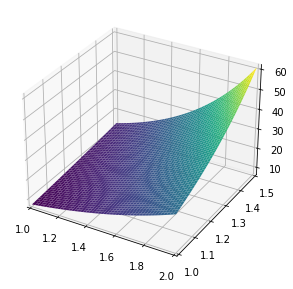

In [20]:
sy.plotting.plot3d(sy.sympify(sensitivity.data), ("x_0", 1, 2), ("x_1", 1, 1.5))

To obtain the Lipschitz constant of the query, we need to maximise the gradient norm by minimising the negative of the norm using a suitable optimiser with a global optimality guarantee. In this case, we use SHGO as described in the paper. The norm (=sensitivity) is AOT-compiled for use with `SciPy`.

In [14]:
norm_func = se.Lambdify(list(sensitivity.data.free_symbols), -sensitivity.data)

SHGO minimises the function given certain constraints, in this case the bounds on the variables.

In [15]:
sol = shgo(norm_func, ((1,2), (1,1.5)))

The solution to the optimisation problem (the inverse of it to be precise) is the Lipschitz constant of the function which can be used to obtain individual privacy guarantees.

In [16]:
-sol.fun #Lipschitz constant

59.22008712736098